In [32]:
# Importing the necessary packages
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [33]:
# Loading the images
imsize = 256

loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()]) # defining a data pipeline that resizes
# and transforms the image to tensor

def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0) # unsqueeze the tensor along dimension 0 to indicate a single example in the batch
    return image.to(torch.float)

content_img = image_loader("images/taj_mahal (1).jpg")
style_img = image_loader("images/style7 (1).jpg")
print(content_img.size())
print(style_img.size())

assert content_img.size() == style_img.size()

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


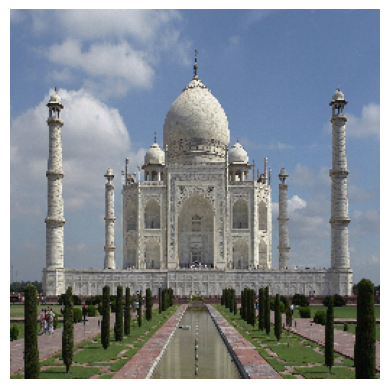

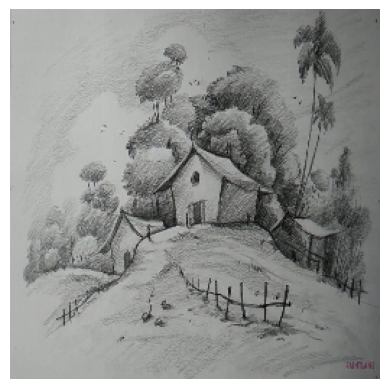

In [34]:
# Visualizing the loaded image
unloader = transforms.ToPILImage() # convert to PIL Image as matplotlib displays PIL images

plt.ion() # enable interactive mode in matplotlib

def imshow(tensor):
    image = tensor.clone()
    image = image.squeeze(0) # removing the batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.axis('off')
    plt.pause(0.001)

plt.figure()
imshow(content_img)

plt.figure()
imshow(style_img)

In [35]:
# Describing content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach() # this is done to detach the target content which does not require gradient computation
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [36]:
# Gram matrix for style loss
def gram_matrix(input):
    batch_size, num_fmaps, height, width = input.size()
    features = input.view(batch_size*num_fmaps, height*width)
    G = torch.mm(features, features.t())
    return G.div(batch_size*num_fmaps*height*width)

In [37]:
# Describing style loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() # this is done to detach the target style which does not require gradient computation
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [38]:
# Importing a pretrained neural network which in this case is VGG19 model
cnn = models.vgg19(pretrained=True).features.eval()

In [39]:
# Creating a module to normalize input image
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std # normalization

In [40]:
# Getting our model ready with ContentLoss and StyleLoss modules in it
content_layers_default = ['conv_4'] # desired depth layer to compute content loss
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # desired depth layers to compute style loss

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std) # normalization module
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False) # replacing the inplace version with the out-of-place one
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1): # trimming off the layers after the last content and style losses
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

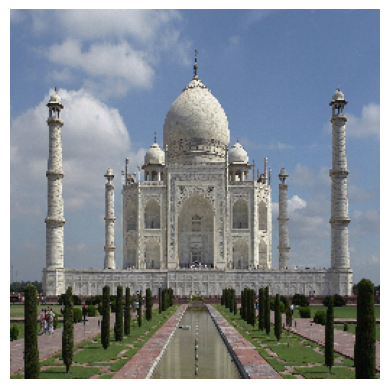

In [41]:
# Selecting the input image
input_img = content_img.clone()
plt.figure()
imshow(input_img)

In [42]:
# Gradient descent optimizer which is used is L-BFGS
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [43]:
# Building our final style transfer function
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=400, style_weight=1000000, content_weight=1):
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print("Optimizing..")
    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run}:")
                print("Style Loss : {:4f} Content Loss: {:4f}".format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\mahes\AppData\Local\Temp\ipykernel_32720\25983039.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\mahes\AppData\Local\Temp\ipykernel_32720\25983039.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 9.705729 Content Loss: 10.680758

run [100]:
Style Loss : 3.739468 Content Loss: 7.953022

run [150]:
Style Loss : 2.549598 Content Loss: 6.913795

run [200]:
Style Loss : 1.903649 Content Loss: 6.342171

run [250]:
Style Loss : 1.494038 Content Loss: 6.051813

run [300]:
Style Loss : 1.202789 Content Loss: 5.848890

run [350]:
Style Loss : 1.012702 Content Loss: 5.702211

run [400]:
Style Loss : 0.910329 Content Loss: 5.594343



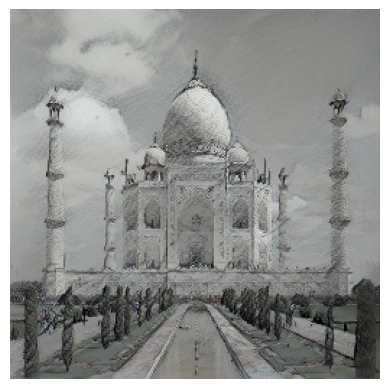

In [44]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output)

plt.ioff()
plt.show()